In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isratanika","key":"3a7c473846fd270574def603f8096410"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d grassknoted/asl-alphabet


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 99% 1.02G/1.03G [00:10<00:00, 173MB/s]
100% 1.03G/1.03G [00:10<00:00, 105MB/s]


In [6]:
!unzip asl-alphabet.zip -d ./asl_dataset


Streaming output truncated to the last 5000 lines.
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: ./asl_dataset/asl_alphabet_tr

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Settings
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_PATH = "./asl_dataset/asl_alphabet_train/asl_alphabet_train"

# ✅ Data Augmentation and Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% for validation
)

# ✅ Training Data Generator
train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# ✅ Validation Data Generator
val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# ✅ Number of Classes
num_classes = len(train_generator.class_indices)

print(f"✅ Number of classes: {num_classes}")
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
✅ Number of classes: 29
✅ Training samples: 69600
✅ Validation samples: 17400


In [8]:
# ✅ Convert generators to tf.data.Dataset for small batch handling
train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).batch(32).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision

# ✅ Enable Mixed Precision for T4 GPU Optimization
mixed_precision.set_global_policy('mixed_float16')

# ✅ Settings
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_PATH = "./asl_dataset/asl_alphabet_train/asl_alphabet_train"


In [10]:
# ✅ Load Dataset and Split into Small Batches
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=True
)

# ✅ Save class_names BEFORE prefetching!
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"✅ Number of classes: {num_classes}")

# ✅ Now Apply Prefetch
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
# ✅ Adjust Steps per Epoch (2700 total steps)
steps_per_epoch = 2700 // BATCH_SIZE
validation_steps = len(val_ds) // BATCH_SIZE


Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
✅ Number of classes: 29


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision

# ✅ Enable Mixed Precision
mixed_precision.set_global_policy('mixed_float16')

# ✅ Data Augmentation (Improves Generalization)
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# ✅ Define Optimized 2-Layer CNN
model_cnn_small = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # ✅ First Layer (Increase filters)
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D((2, 2)),

    # ✅ Second Layer (Increase filters)
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D((2, 2)),

    # ✅ Use GlobalAveragePooling instead of Flatten
    GlobalAveragePooling2D(),

    Dense(256),
    LeakyReLU(),
    Dropout(0.5),  # ✅ Increased dropout for better regularization

    Dense(num_classes, activation='softmax')
])

# ✅ Compile Model with Slightly Higher Learning Rate
model_cnn_small.compile(
    optimizer=Adam(learning_rate=0.0005),  # ✅ Increased learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Model Summary
model_cnn_small.summary()







Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           7,453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,893 (456.61 KB)

 Trainable params: 116,509 (455.11 KB)

 Non-trainable params: 384 (1.50 KB)

In [13]:
# ✅ Early Stopping to Avoid Overfitting
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# ✅ Learning Rate Scheduler (reduces LR on plateau)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# ✅ Train Small CNN Model
history_cnn_small = model_cnn_small.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 90s 41ms/step - accuracy: 0.3920 - loss: 1.8985 - val_accuracy: 0.1361 - val_loss: 4.4767 - learning_rate: 2.5000e-04
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 90s 41ms/step - accuracy: 0.4703 - loss: 1.6120 - val_accuracy: 0.0835 - val_loss: 7.7513 - learning_rate: 2.5000e-04
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 91s 42ms/step - accuracy: 0.5114 - loss: 1.4768 - val_accuracy: 0.1966 - val_loss: 4.1718 - learning_rate: 2.5000e-04
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 142s 42ms/step - accuracy: 0.5480 - loss: 1.3669 - val_accuracy: 0.1817 - val_loss: 5.3407 - learning_rate: 2.5000e-04
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 142s 42ms/step - accuracy: 0.5739 - loss: 1.2754 - val_accuracy: 0.2693 - val_loss: 3.6458 - learning_rate: 2.5000e-04
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 90s 41ms/step - accuracy: 0.5933 - loss: 1.2132 - val_accuracy: 0.0566 - val_loss: 10.5481 - learning_rate: 2.5000e-04
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Step 1: Define Evaluation Metrics
def compute_metrics(y_true, y_pred):
    # Ensure both are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1-score": f1
    }

print("✅ Evaluation Metrics Defined!")

# ✅ Step 2: Define Custom Evaluation Function for Small CNN Model
class CNNSmallEvaluator:
    def __init__(self, model, val_ds):
        self.model = model
        self.val_ds = val_ds

    def evaluate(self):
        print("\n🔍 Evaluating Small CNN Model...")

        y_true = []
        y_pred = []

        # ✅ Collect true and predicted labels batch-by-batch
        for images, labels in self.val_ds:
            logits = self.model.predict(images, verbose=0)

            # ✅ Extract predicted class
            predictions = np.argmax(logits, axis=-1)

            # ✅ Collect true labels and predicted labels
            y_true.extend(np.argmax(labels.numpy(), axis=-1))  # Convert one-hot to label index
            y_pred.extend(predictions)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # ✅ Compute Metrics
        metrics = compute_metrics(y_true, y_pred)

        # ✅ Print Results (Like TensorFlow Format)
        print("\n✅ FINAL MODEL RESULTS ✅")
        for key, value in metrics.items():
            print(f"{key}: {value:.5f}")

        return metrics  # Ensure the function returns metrics

# ✅ Step 3: Run Evaluation for Small CNN Model
if 'model_cnn_small' in locals():
    evaluator = CNNSmallEvaluator(model_cnn_small, val_ds)
    eval_results = evaluator.evaluate()

    # ✅ Save to Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    model_cnn_small.save('/content/drive/MyDrive/asl_cnn_small.h5')
    print("✅ Small CNN model saved to Google Drive!")


✅ Evaluation Metrics Defined!

🔍 Evaluating Small CNN Model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



✅ FINAL MODEL RESULTS ✅
accuracy: 0.59167
precision: 0.63972
recall: 0.59167
f1-score: 0.55010


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Small CNN model saved to Google Drive!


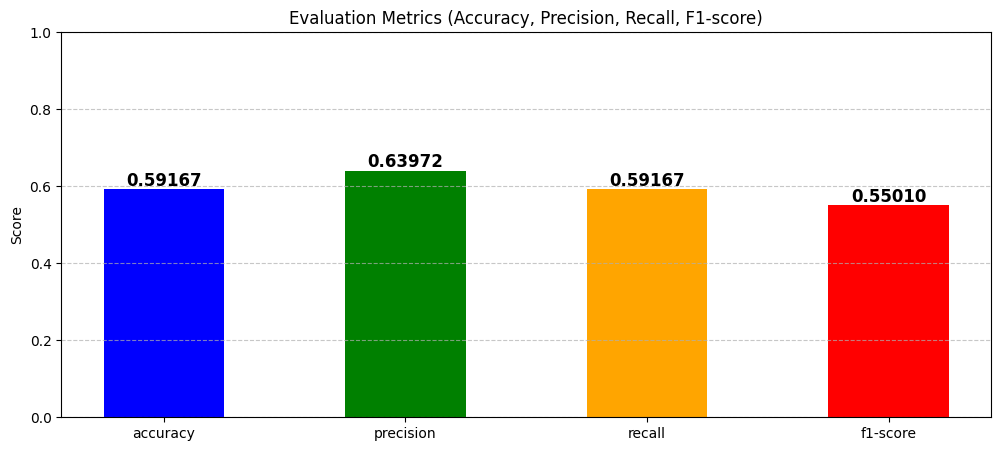

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ Define evaluation metrics (from previous evaluation results)
eval_metrics = {
    "accuracy": 0.59167,
    "precision": 0.63972,
    "recall": 0.59167,
    "f1-score": 0.55010
}

# ✅ Function to plot training accuracy & loss
def plot_training_history(history, model_name="CNN"):
    plt.figure(figsize=(12, 5))

    # ✅ Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'{model_name} - Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # ✅ Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='purple')
    plt.title(f'{model_name} - Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ✅ Function to plot Accuracy, Precision, Recall, and F1-score side by side
def plot_eval_metrics(metrics):
    plt.figure(figsize=(12, 5))

    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    colors = ["blue", "green", "orange", "red"]

    plt.bar(metric_names, metric_values, color=colors, width=0.5)
    plt.ylabel("Score")
    plt.ylim(0, 1.0)  # ✅ Adjusted y-axis for better visualization
    plt.title("Evaluation Metrics (Accuracy, Precision, Recall, F1-score)")

    for i, v in enumerate(metric_values):
        plt.text(i, v, f"{v:.5f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# ✅ Plot training accuracy & loss
if 'history_cnn' in locals():
    plot_training_history(history_cnn, model_name="Reduced CNN")

# ✅ Plot Accuracy, Precision, Recall & F1-score together
plot_eval_metrics(eval_metrics)
